### Load Network and See feature map

In [1]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras.models import Model, load_model
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

# import metrics

from keras.layers import Input, Dense, GRU, Embedding,Lambda
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate as concat

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.models import load_model
from keras.models import model_from_json

from time import time
import numpy as np
import pandas as pd
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD,Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans




Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(300, 400, 3), activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))

model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

# model.add(Dense(1))
model.add(Dense(4,activation='softmax'))

optimizer = Adam(lr=1e-3)

model.compile(optimizer=optimizer, loss='categorical_crossentropy')



/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", input_shape=(300, 400,..., strides=(2, 2))`
  
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  """
/home/home9sec

In [6]:
try:
    model = load_model('./CNNModel/cnnmodel.h5')
except:
    pass


In [3]:
import gzip 

try:
    np_data = []
    with gzip.open( './data/DJI/test_pic.npy.gz', 'r') as infile:
        _tmp_np_data = np.load(infile)
        np_data.append(_tmp_np_data)
except Exception as e:
    print(e)

(890, 300, 400, 3)


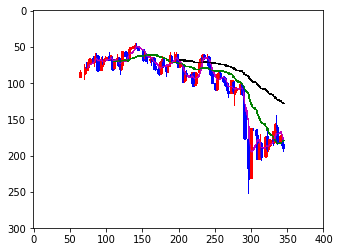

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt 
print(np_data[0].shape)
plt.imshow(np_data[0][0])

In [7]:
_input = np_data[0]
y_pred = model.predict(_input)

In [11]:
cls_pred = np.argmax(y_pred, axis=1)
cls_pred[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder() # one hot encode the target classes

df_test = pd.read_pickle('./data/DJI/df_test.pkl')
               
# print("df_train {}".format(df_train.shape))

df_test['id'] = 0
df_test.loc[(df_test['signal_5ma'] == 9) , ['id']] = 1
df_test.loc[(df_test['signal_5ma'] == 8) , ['id']] = 2
df_test.loc[(df_test['signal_5ma'] == -9) , ['id']] = 3
df_test.loc[(df_test['signal_5ma'] == 0) , ['id']] = 0

_valin = df_test['id'].values


np_target = one_hot.fit_transform(np.reshape(_valin, (-1,1)) ).toarray()
np_target.shape

/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(890, 4)

In [12]:
_valin[:10]

array([0, 0, 0, 0, 0, 0, 1, 2, 2, 2])

In [19]:
res = (cls_pred == _valin)
correct_num = np.where(res == True)

success_rate = correct_num[0].shape[0]/cls_pred.shape[0]
success_rate



0.6112359550561798

In [9]:
_evalresult = model.evaluate(x=_input,y=np_target)

890/890 [==============================] - 32s 36ms/step


In [10]:
_evalresult

6.266136047277557

### Visualize weights layers

In [26]:
import math 

def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 198, 24)      1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 97, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 47, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 45, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 43, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 82560)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               8256100   
__________

In [28]:
layer_conv1 = model.layers[0]
layer_conv1

In [29]:
weights_conv1 = layer_conv1.get_weights()[0]
weights_conv1.shape

(5, 5, 3, 24)

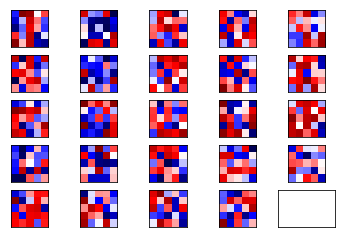

In [34]:
plot_conv_weights(weights=weights_conv1, input_channel=1)

### Keras softmax classification 

In [ ]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.layers import Dense, Input, concatenate, Dropout
from keras.models import Model
from keras.optimizers import rmsprop

dataset = load_wine()

ensemble_num = 10 # number of sub-networks
bootstrap_size = 0.8 # 80% size of original (training) dataset
training_size = 0.8 # 80% for training, 20% for test

num_hidden_neurons = 10 # number of neurons in hidden layer
dropout = 0.25 # percentage of weights dropped out before softmax output (this prevents overfitting)

epochs = 200 # number of epochs (complete training episodes over the training set) to run
batch = 10 # mini batch size for better convergence

# get the holdout training and test set
temp = []
scaler = MinMaxScaler()
one_hot = OneHotEncoder() # one hot encode the target classes
dataset['data'] = scaler.fit_transform(dataset['data'])
dataset['target'] = one_hot.fit_transform(np.reshape(dataset['target'], (-1,1)) ).toarray()
for i in range(len(dataset.data)):
    temp.append([dataset['data'][i], np.array(dataset['target'][i])])

# shuffle the row of data and targets
temp = np.array(temp)
np.random.shuffle(temp)
# holdout training and test stop index
stop = int(training_size*len(dataset.data))

train_X = np.array([x for x in temp[:stop,0]])
train_Y = np.array([x for x in temp[:stop,1]])
test_X = np.array([x for x in temp[stop:,0]])
test_Y = np.array([x for x in temp[stop:,1]])

# now build the ensemble neural network
# first, let's build the individual sub-networks, each
# as a Keras functional model.
sub_net_outputs = []
sub_net_inputs = []
for i in range(ensemble_num):
    # two hidden layers to keep it simple
    # specify input shape to the shape of the training set
    net_input = Input(shape = (train_X.shape[1],))
    sub_net_inputs.append(net_input)
    y = Dense(num_hidden_neurons)(net_input)
    y = Dense(num_hidden_neurons)(y)
    y = Dropout(dropout)(y)
    sub_net_outputs.append(y) # sub_nets contains the output tensors

# now concatenate the output tensors
y = concatenate(sub_net_outputs)

# final softmax output layer
y = Dense(train_Y[0].shape[0], activation='softmax')(y)

# now build the whole funtional model
model = Model(inputs=sub_net_inputs, outputs=y)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

print("Begin training...")

# train the model
model.fit( [train_X] * ensemble_num, train_Y,validation_data=[ [test_X] * ensemble_num, test_Y],
          epochs=epochs, batch_size=batch)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
width, height, channels = trainX.shape[1], trainX.shape[2], 1
trainX = trainX.reshape((trainX.shape[0], width, height, channels))
testX = testX.reshape((testX.shape[0], width, height, channels))
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = datagen.flow(trainX, trainY, batch_size=64)
print(train_iterator)
test_iterator = datagen.flow(testX, testY, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
